In [1]:
import pandas as pd
import numpy as np
import sys, os
import time
import re
from operator import itemgetter

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.dummy import DummyClassifier

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.utils import np_utils, generic_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
import tensorflow as tf

from xgboost import XGBClassifier

from tsfresh import extract_features, select_features

from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

Using TensorFlow backend.


## Data Preprocessing 
transform raw data into daily return data

In [2]:
def drop_null_rows(df, colname_list):
    for colname in colname_list:
        try:
            df = df[df[colname]!="null"].copy()
        except:
            pass
    return df

def drop_zero_rows(df, colname_list):
    for colname in colname_list:
        df = df[df[colname]!=0].copy()
    return df

def get_close_close_data(path, min_sample, min_start_date):
    df_list = []
    for fname in os.listdir(path):
        df = pd.read_csv(os.path.join(path, fname), sep = ",")     
        nb_rows = df.shape[0]
    
        # drop rows where "null" is appeared
        df = drop_null_rows(df, ["Close", 'Open'])
        dropped_null_rows = df.shape[0] - nb_rows
        if dropped_null_rows > 0:
            print("Dropped null rows at {}: {:d}".format(fname, dropped_null_rows))

        # only keep files where:
        # - sample size > min_sample
        # - first active date < min_start_date
        if df.shape[0] > min_sample and df['Date'][0] <= min_start_date:
            colname = fname.split(".")[0]
            df[colname] = np.log(df['Close'].astype(float)/df['Close'].shift().astype(float))
            df = df[['Date', colname]].copy()
            df.set_index("Date", inplace = True)
            df_list.append(df)
    return df_list

def main_load_close_close(from_path, to_path, to_name, min_sample = 2000, min_start_date = "2009-01-01"):
    df_list = get_close_close_data(path = from_path, min_sample = min_sample, min_start_date = min_start_date)
    df_all = pd.concat(df_list, axis = 1)
    
    df_all = df_all.fillna(method='ffill')
    df_all = df_all.loc[df_all.index >= min_start_date]
    
    df_all.to_csv(os.path.join(to_path, to_name), sep = ";", header = True, index = True)
    return df_all

In [3]:
stock_return_df = main_load_close_close(from_path = "shared_data/stocks", to_path = "shared_data", to_name = "sp_close_close_return.csv")
index_return_df = main_load_close_close(from_path = "shared_data/index", to_path = "shared_data", to_name = "index_close_close_return.csv")

c:\users\jiaoy\appdata\local\programs\python\python35\lib\site-packages\pandas\core\ops.py:714: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


In [4]:
print("Nb of stocks kept: {}".format(stock_return_df.shape[1]))
print("Indexes kept: {}".format(list(index_return_df.columns)))

Nb of stocks kept: 463
Indexes kept: ['aord', 'dax', 'djia', 'ftse', 'hangseng', 'nikkei', 'nyse', 'snp']


## Feature Extraction

In [5]:
def make_one_lag_feature(mydf, colname, lag):
    arr = mydf[colname]
    feat_name = "{}_lag_{:d}".format(colname, lag)
    lagged_arr = arr.shift(lag)
    return feat_name, lagged_arr

def build_lag_features(mydf, stock_name, lag_list = [1, 2, 3, 4, 5], verbose = False):
    """
    Build lag features from given dataframe
    """
    res_df = pd.DataFrame()
    for lag in lag_list:
        feat_name, lagged_arr = make_one_lag_feature(mydf, stock_name, lag)
        res_df[feat_name] = lagged_arr
    if verbose:
        print("Feature set size:", res_df.shape)
    return res_df

def main_save_lag_features(mydf, folder_name = "self_lag_5", lag_list = [1, 2, 3, 4, 5], verbose = False):
    to_dir = os.path.join("shared_data", "features", folder_name)
    if not os.path.isdir(to_dir):
        os.makedirs(to_dir)
    for stock_name in mydf.columns:
        feat_df = build_lag_features(mydf = mydf, stock_name = stock_name, lag_list = lag_list, verbose = verbose)
        feat_df.to_csv(os.path.join(to_dir, "{}.csv".format(stock_name)), index = True, header = True, sep = ";")

In [6]:
main_save_lag_features(mydf = index_return_df, folder_name = "index_lag_5", lag_list = [1, 2, 3, 4, 5], verbose = False)
main_save_lag_features(mydf = stock_return_df, folder_name = "self_lag_5", lag_list = [1, 2, 3, 4, 5], verbose = False)

## Feature Processing

In [7]:
FEAT_DIR = os.path.join("shared_data", "features")
RES_DIR = os.path.join("shared_data", "result")
TEST_RES_DIR = os.path.join(RES_DIR, "testset")
# load the return data of all assets
TARGET_DF = pd.read_csv("shared_data/sp_close_close_return.csv", sep = ";", header = 0, index_col = 0)
TARGET_DF_INDEX = pd.read_csv("shared_data/index_close_close_return.csv", sep = ";", header = 0, index_col = 0)
EUR_INDEX = ["dax", "ftse"]
USA_INDEX = ["djia", "nyse", "snp"]
ASIA_INDEX = ["aord", "hangseng", "nikkei"]

In [8]:
def format_feat_df(feat_df, verbose = True):
    """
    Clena up raw feature df that may contain NA
    """
    tot = feat_df.shape[0]
    # drop rows containing na
    feat_df.dropna(how = "any", inplace = True, axis = 0)
    if verbose:
        print("dropped na rows: ", tot - feat_df.shape[0])
    
    target = (feat_df['target'].values > 0).astype(int)
    feat_df = feat_df.drop("target", axis = 1)
    return feat_df, target 

def load_features(asset_name, feature_name_list, feature_dir = FEAT_DIR, target_df = TARGET_DF, verbose = True, 
                  europe_lag = -1, asia_lag = -1, usa_lag = 0):
    """
    Params:
    -------
    asset_name: str
        the name of the target asset
    
    feature_name_list: str
        what feature sets we'll be using, each feature name corresponds to a folder name
        if feature_name begins with "self", then we need to load the feature file with the name of the given asset,
        if feature_name begins with "index", then load all features in given folde
        
    feature_dir: str
        location of feature data
    
    verbose: bool
        whether to show execution messages
        
    europe_lag: int
        additional lag applied on europe data
    
    asia_lag: int
        additional lag applied on asia data
    
    usa_lag: int
        additional lag applied on usa data
    """
    feat_df_list = []
    if verbose:
        print("******* loading features on {} *******".format(asset_name))
    for feature_name in feature_name_list:
        if re.search("^self_", feature_name):
            # if the feature name begins with self_, then just load corresponding data file
            feat_path = os.path.join(feature_dir, feature_name, "{}.csv".format(asset_name))
            df = pd.read_csv(feat_path, sep = ";", header = 0, index_col = 0)
            feat_df_list.append(df)
        elif re.search("^index_", feature_name):
            # if the feature_name begins with index_, use all the features in the folder as features
            current_dir = os.path.join(feature_dir,  feature_name)
            for fname in os.listdir(current_dir):
                feat_path = os.path.join(current_dir, fname)
                df = pd.read_csv(feat_path, sep = ";", header = 0, index_col = 0)
                if re.search("|".join(EUR_INDEX), fname) and (europe_lag != 0):
                    # europe market data
                    df = df.shift(europe_lag)
                    df.columns = ["{}_lag_{}".format(x, europe_lag) for x in df.columns]
                elif re.search("|".join(ASIA_INDEX), fname) and (asia_lag != 0):
                    df = df.shift(asia_lag)
                    df.columns = ["{}_lag_{}".format(x, asia_lag) for x in df.columns]
                elif re.search("|".join(USA_INDEX), fname) and (usa_lag != 0):
                    df = df.shift(usa_lag)
                    df.columns = ["{}_lag_{}".format(x, usa_lag) for x in df.columns]
                
                feat_df_list.append(df)
        
    feat_df = pd.concat(feat_df_list, axis = 1)
    
    if verbose:
        print("raw feature shape: {}".format(feat_df.shape))
    
    feat_df['target'] = target_df[asset_name]
    
    feat_df, target = format_feat_df(feat_df, verbose)
    
    if verbose:
        print("cleaned feature shape: {}".format(feat_df.shape))
    
    return feat_df, target

## Validation Split

In [9]:
def validation_split_data(X, y, mode, nb_days = 252):
    """
    split data for validation purpose (or asset selection)
    
    Params:
    -------
    mode: str
        - "cv": classic 5 folds cross validation
        - "test", classic train test split, using one year of data as test 
        - "ts", time series based 5 folds sequential splitting
    nb_days: int
        nb of trading days a year
    
    Returns:
    --------
    out: list
        list of 4-tuples (X_train, y_train, X_test, y_test)
    """
    train_test_list = []
    
    if mode == "single":
        X_train = X[:nb_days, :]
        X_test = X[-nb_days:, :]

        y_train = y[:nb_days]
        y_test = y[-nb_days:]
        
        train_test_list.append((X_train, y_train, X_test, y_test))
    elif mode == "cv":
        cv = KFold(n_splits = 5, shuffle = False, random_state = 2017)
        for train_index, test_index in cv.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            train_test_list.append((X_train, y_train, X_test, y_test))
    elif mode == "ts":
        ts = TimeSeriesSplit(n_splits = 5)
        for train_index, test_index in ts.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            train_test_list.append((X_train, y_train, X_test, y_test))
    else:
        print("split mode undefined: {}".format(mode))
        sys.exit(1)
    return train_test_list 

def main_split_data(X, y, mode, nb_days = 252):
    """
    Params:
    -------
    X: numpy ndarray
        training variables
    y: array like
        target variable
    mode: str
        "cv", "test" or "ts"
    
    Returns:
    --------
    out: (4-tuple, list of 4-tuples)
        (X_train, y_train, X_test, y_test), list of 4 tuples for validation purpose
    """
    # First split out test set which is the last one year data
    X_train = X[:-nb_days, :]
    X_test = X[-nb_days:, :]
    
    # this test set will be used to compare all strategies
    y_train = y[:-nb_days]
    y_test = y[-nb_days:]
    
    # split the training set for validation purpose
    validation_list = validation_split_data(X = X_train, y = y_train, mode = mode, nb_days = nb_days)
    return (X_train, y_train, X_test, y_test), validation_list

## Predicting

In [10]:
def predict_on_validation_list(validation_list, clf, out_name, folder_name, out_dir = RES_DIR, verbose = True, to_save = True):
    """
    Run prediction and save result to disk 
    
    Params:
    --------
    validation_list: list of 4-tuples
        (X_train, y_train, X_test, y_test) tuples
    clf: predictor
        fit and predict
    out_name: str
        result file name, usaully set to asset name itself
    folder_name: str
        the method name used as the folder name to save all the prediction results 
    
    """
    # res_df = pd.DataFrame()
    to_dir = os.path.join(out_dir, folder_name)
    
    if verbose:
        print("**** Running Prediction on {} with {} *****".format(out_name, folder_name))
    
    if not os.path.isdir(to_dir):
        os.makedirs(to_dir)
    
    out_path = os.path.join(to_dir, "{}.csv".format(out_name))
    acc_list, auc_list = [], []
    
    res_df_list = []
    for i, (X_train, y_train, X_test, y_test) in enumerate(validation_list):
        res_df = pd.DataFrame()
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:, 1]
        
        res_df["true_{}".format(i)] = y_test
        res_df["pred_{}".format(i)] = y_pred
        
        res_df_list.append(res_df)

        auc = roc_auc_score(y_test, y_pred)
        acc = accuracy_score(y_test, (y_pred > 0.5).astype(int))
        
        auc_list.append(auc)
        acc_list.append(acc)
            
    res_df = pd.concat(res_df_list, axis = 1)
    
    if verbose:
        print("Result on {} - avg AUC: {:0.4f}, avg Accuracy: {:0.4f}".format(out_name, np.mean(auc_list), np.mean(acc_list)))
    
    if to_save:
        res_df.to_csv(out_path, index = False, header = True, sep = ";")
    
    return np.mean(auc_list)

def main_predict_all_stocks_on_validation(feature_name_list, 
                                   validation_mode, 
                                   clf, 
                                   clf_name,                                  
                                   verbose = True, 
                                   nn_param_dict = None):
    """
    Run prediction on all assets
    
    Params:
    -------
    feature_name_list: list of str
        list of feature set to use
    
    validation_mode: str
        "test", "cv", or "ts". It defines which validation scheme to use
    
    clf: predictor
    
    clf_name: str
        predictor's name
    
    verbose: bool
        whether to show execution messages
        
    """
    # method_name identifies the current approach 
   
    method_name = "-".join(["+".join(feature_name_list), clf_name, validation_mode])
    
    t0 = time.time()
    
    # df_raw will be used to extract target variables
   
    df_raw = TARGET_DF
   
    # get the name of all assets
    asset_list = df_raw.columns
    tot = len(asset_list)
    for i, asset_name in enumerate(asset_list):
        # load feature set
        to_path = os.path.join(RES_DIR, method_name, "{}.csv".format(asset_name))
       
        feat_df, target = load_features(
                                        asset_name = asset_name, 
                                        feature_name_list = feature_name_list, 
                                        feature_dir = FEAT_DIR, 
                                        target_df = df_raw,
                                        verbose = verbose)

        ss = StandardScaler()
        X = ss.fit_transform(feat_df.values)
        y = np.array(list(target))

        # split
        (X_train, y_train, X_test, y_test), validation_list = main_split_data(X = X, y = y, mode = validation_mode)

        # run prediction
        predict_on_validation_list(validation_list = validation_list, 
                                   clf = clf, 
                                   out_name = asset_name, 
                                   folder_name = method_name,
                                   out_dir = RES_DIR, 
                                   verbose = False, 
                                   to_save = True)
        if verbose:
            print("{}/{} Ended".format(i + 1, tot))
    
    print("Total time spend: {} mins".format((time.time() - t0)//60))

def main_predict_sp500_index_on_validation(feature_name_list, validation_mode, 
                                     clf, clf_name, to_std = True, 
                                     verbose = True, 
                                     nn_param_dict = None, 
                                     to_save = True):
    """
    We only predict the sp500 index for now
    """
    
    asset_name = "snp"
   
    method_name = "-".join(["+".join(feature_name_list), clf_name, validation_mode])
    
    df_raw = TARGET_DF_INDEX
    
    to_path = os.path.join(RES_DIR, method_name, "{}.csv".format(asset_name))
    
   
    feat_df, target = load_features(
                                    asset_name = asset_name, 
                                    feature_name_list = feature_name_list, 
                                    feature_dir = FEAT_DIR, 
                                    target_df = df_raw,
                                    verbose = False)


    ss = StandardScaler()
    X = ss.fit_transform(feat_df.values)
    y = np.array(list(target))

    # split
    (X_train, y_train, X_test, y_test), validation_list = main_split_data(X = X, y = y, mode = validation_mode)

    # run prediction
    return predict_on_validation_list(validation_list = validation_list, 
                               clf = clf, 
                               out_name = asset_name, 
                               folder_name = method_name,
                               out_dir = RES_DIR, 
                               verbose = False, 
                               to_save = to_save)  

In [11]:
lr_best = LogisticRegression(penalty = "l1", C = 0.05)
main_predict_all_stocks_on_validation(feature_name_list = ["self_lag_5", "index_lag_5"], 
                               validation_mode = "ts", 
                               clf = lr_best, 
                               clf_name = "logistic-regression", 
                               verbose = False)

Total time spend: 0.0 mins


## Evaluation 

In [12]:
def get_auc_list_from_dir(folder_name, result_dir = RES_DIR):
    from_dir = os.path.join(result_dir, folder_name)
    auc_list = []
    for filename in os.listdir(from_dir):
        df = pd.read_csv(os.path.join(from_dir, filename), sep = ";", header = 0, index_col = None)
        nb = int(df.shape[1]/2)
        tmp_auc_list = []
        for i in range(nb):
            y_pred = df['pred_{}'.format(i)].values
            y_test = df['true_{}'.format(i)].values
            auc = roc_auc_score(y_test, y_pred)
            tmp_auc_list.append(auc)
        auc = np.mean(tmp_auc_list)
        auc_list.append(auc)
    return auc_list  

def show_overall_performance(folder_name, result_dir = RES_DIR, show_hist = False):
    from_dir = os.path.join(result_dir, folder_name)
    acc_list = []
    auc_list = []
    for filename in os.listdir(from_dir):
        df = pd.read_csv(os.path.join(from_dir, filename), sep = ";", header = 0, index_col = None)
        nb = int(df.shape[1]/2)
        tmp_auc_list = []
        tmp_acc_list = []
        for i in range(nb):
            y_pred = df['pred_{}'.format(i)].values
            y_test = df['true_{}'.format(i)].values
            auc = roc_auc_score(y_test, y_pred)
            tmp_auc_list.append(auc)
            acc = accuracy_score(y_test, (y_pred > 0.5).astype(int))
            tmp_acc_list.append(acc)
        
        auc_list.append(np.mean(tmp_auc_list))
        acc_list.append(np.mean(tmp_acc_list))
    
    print("Result on {} - avg AUC: {:0.4f} with std: {:0.4f}, avg Accuracy: {:0.4f} with std: {:0.4f}".\
          format(folder_name, np.mean(auc_list), np.std(auc_list), np.mean(acc_list), np.std(acc_list))) 
    if show_hist:
        plt.hist(auc_list, bins = 30, alpha=0.5, label="AUC")
        plt.legend(loc='upper right')
        plt.show()
    
    return np.mean(auc_list)

Result on self_lag_5+index_lag_5-logistic-regression-ts - avg AUC: 0.6942 with std: 0.0381, avg Accuracy: 0.6376 with std: 0.0294


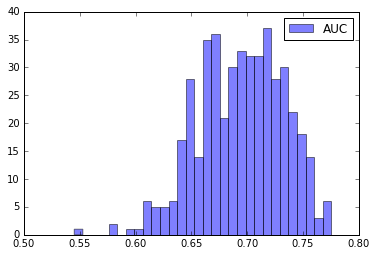

0.69424496743601383

In [13]:
show_overall_performance(folder_name = "self_lag_5+index_lag_5-logistic-regression-ts", show_hist = True)